In [1]:
# Install dependencies
!pip install -q groq pydantic scikit-learn numpy pandas matplotlib seaborn
!pip install -q -U sentence-transformers

# Core imports
import time
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from groq import Groq
from google.colab import userdata
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel, Field, ValidationError
from sentence_transformers import SentenceTransformer, util
GROQ_KEY = userdata.get("GROQ_API_KEY")

client = Groq(api_key=GROQ_KEY)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 4.3 MB/s eta 0:00:00


In [2]:
embed_model = SentenceTransformer('all-MiniLM-L6-v2')



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
def run_prompt(prompt: str):
    start_time = time.time()

    completion = client.chat.completions.create(
        model="llama-3.3-70b-versatile",  # confirm model name in Groq dashboard
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.3
    )
    end_time = time.time()
    latency_ms = (end_time - start_time) * 1000
    output_text = completion.choices[0].message.content
    approx_tokens = len(output_text.split())
    return output_text, latency_ms, approx_tokens


In [4]:
def get_embedding(text: str):
    return embed_model.encode(text)
def compute_similarity(model_output: str, reference):
    """
    If structured JSON reference is provided, compare answer fields.
    Otherwise fallback to full-text similarity.
    """

    try:
        is_valid, model_obj = ReliabilityReport.extract_and_validate(model_output)

        # If reference is structured JSON
        if isinstance(reference, dict) and is_valid:
            model_answer = model_obj.answer
            reference_answer = reference.get("answer", "")
        else:
            model_answer = model_output
            reference_answer = reference

        emb1 = get_embedding(model_answer)
        emb2 = get_embedding(reference_answer)

        return cosine_similarity([emb1], [emb2])[0][0]

    except:
        return 0.0


In [5]:
def check_hallucination(prompt: str, response: str):
    """
    Improved factual accuracy auditing.
    Returns normalized score between 0 and 1.
    """

    eval_prompt = f"""
You are a strict factual auditor.

Evaluate whether the AI response is factually correct.

Be critical:
- Penalize factual inaccuracies
- Penalize overconfident claims
- Penalize unsupported reasoning
- Penalize mathematical errors
- Penalize vague or misleading answers

Question:
{prompt}

Response:
{response}

Provide short reasoning, then output:

ACCURACY_SCORE: X

Where X is a number from 0 to 10.
"""

    try:
        completion = client.chat.completions.create(
            model="llama-3.3-70b-versatile",
            messages=[{"role": "user", "content": eval_prompt}],
            temperature=0
        )

        content = completion.choices[0].message.content

        match = re.search(r"ACCURACY_SCORE:\s*(\d+(\.\d+)?)", content)

        if match:
            raw_score = float(match.group(1))
            normalized = raw_score / 10.0
            return max(0.0, min(1.0, normalized))

        return 0.5

    except:
        return 0.5


In [6]:
class ReliabilityReport(BaseModel):
    answer: str
    confidence: float = Field(..., ge=0.0, le=1.0)
    reasoning: str

    @staticmethod
    def extract_and_validate(raw_text: str):
        """
        Extract and validate structured JSON output from LLM response.
        Handles markdown code blocks and minor formatting inconsistencies.
        """

        try:
            cleaned = raw_text.strip()

            # Remove markdown code fences
            cleaned = re.sub(r"```json\s*", "", cleaned)
            cleaned = re.sub(r"```", "", cleaned)

            # Extract first valid JSON object
            match = re.search(r"\{.*\}", cleaned, re.DOTALL)
            if not match:
                return False, None

            json_str = match.group(0)
            data = json.loads(json_str)

            # Normalize confidence field
            if "confidence" in data:
                conf = data["confidence"]

                if isinstance(conf, str):
                    conf = conf.replace('%', '').strip()
                    conf = float(conf)
                    if conf > 1:
                        conf = conf / 100.0
                    data["confidence"] = conf

                elif isinstance(conf, (int, float)) and conf > 1:
                    data["confidence"] = conf / 100.0

            validated = ReliabilityReport(**data)
            return True, validated

        except (json.JSONDecodeError, ValidationError, ValueError):
            return False, None


In [12]:
def evaluate_prompt(prompt: str, reference_answer: str = None):

    output_text, latency, tokens = run_prompt(prompt)

    # Structure validation
    is_valid, report_obj = ReliabilityReport.extract_and_validate(output_text)
    structure_score = 1.0 if is_valid else 0.0

    # Semantic similarity
    similarity_score = 0.0
    if reference_answer:
        similarity_score = compute_similarity(output_text, reference_answer)

    # Hallucination check (always run)
    hallucination_score = check_hallucination(prompt, output_text)

    final_reliability_score = (
    0.5 * similarity_score +
    0.5 * hallucination_score
)

    return {
    "similarity": similarity_score,
    "hallucination": hallucination_score,
    "final": final_reliability_score,
    "latency": latency,
    "tokens": tokens
}

In [13]:
test_prompt = """
You are a structured JSON generator.

STRICT INSTRUCTIONS:
- Output MUST be valid JSON.
- No explanation.
- No extra text.
- No markdown formatting.
- Do NOT wrap in ```json blocks.
- Only return raw JSON.

Schema:
{
  "answer": string,
  "confidence": float between 0 and 1,
  "reasoning": string
}

Question: What are the benefits of electric vehicles?
"""
reference_answer = {
    "answer": "Electric vehicles reduce carbon emissions, lower fuel dependency, and require less maintenance.",
    "confidence": 1.0,
    "reasoning": "They produce no tailpipe emissions and require fewer mechanical components."
}


result = evaluate_prompt(test_prompt, reference_answer)

result


{'similarity': np.float32(0.8681727),
 'hallucination': 0.8,
 'final': np.float32(0.83408636),
 'latency': 316.82348251342773,
 'tokens': 45}

In [14]:
showcase_dataset = [
    {"prompt": "What is the boiling point of water?", "reference": "100°C at sea level."},
    {"prompt": "Who wrote 'Romeo and Juliet'?", "reference": "William Shakespeare."},
    {"prompt": "Solve for x: 2x + 5 = 15.", "reference": "x = 5."},
    {"prompt": "Define Photosynthesis.", "reference": "Process by which plants use sunlight to make food."},
    {"prompt": "What is the capital of Japan?", "reference": "Tokyo."},
    {"prompt": "Explain gravity like I'm five.", "reference": "A force that pulls things toward the center of the Earth."},
    {"prompt": "What is the largest mammal?", "reference": "The Blue Whale."},
    {"prompt": "How many continents are there?", "reference": "There are 7 continents."},
    {"prompt": "What is 15% of 200?", "reference": "30."},
    {"prompt": "Who painted the Mona Lisa?", "reference": "Leonardo da Vinci."},
    {"prompt": "What gas do humans breathe out?", "reference": "Carbon Dioxide (CO2)."},
    {"prompt": "What is the currency of the UK?", "reference": "British Pound Sterling."},
    {"prompt": "Name the three states of matter.", "reference": "Solid, liquid, and gas."},
    {"prompt": "What is the square root of 64?", "reference": "8."},
    {"prompt": "Tell me a joke about robots.", "reference": "Why did the robot go on vacation? To recharge its batteries."}
]

In [15]:
records = []

for item in showcase_dataset:
    prompt = item["prompt"]
    reference = item["reference"]

    result = evaluate_prompt(prompt, reference)

    records.append({
    "Prompt": prompt[:40],
    "Similarity": result["similarity"],
    "Hallucination": result["hallucination"],
    "Final Score": result["final"]
})


df = pd.DataFrame(records)
df


,Prompt,Similarity,Hallucination,Final Score
0,What is the boiling point of water?,0.569065,0.9,0.734533
1,Who wrote 'Romeo and Juliet'?,0.565259,1.0,0.782629
2,Solve for x: 2x + 5 = 15.,0.668856,1.0,0.834428
3,Define Photosynthesis.,0.676394,0.9,0.788197
4,What is the capital of Japan?,0.646676,1.0,0.823338
5,Explain gravity like I'm five.,0.414582,0.4,0.407291
6,What is the largest mammal?,0.624557,0.9,0.762279
7,How many continents are there?,0.826949,0.9,0.863475
8,What is 15% of 200?,0.270734,1.0,0.635367
9,Who painted the Mona Lisa?,0.544779,0.9,0.722389


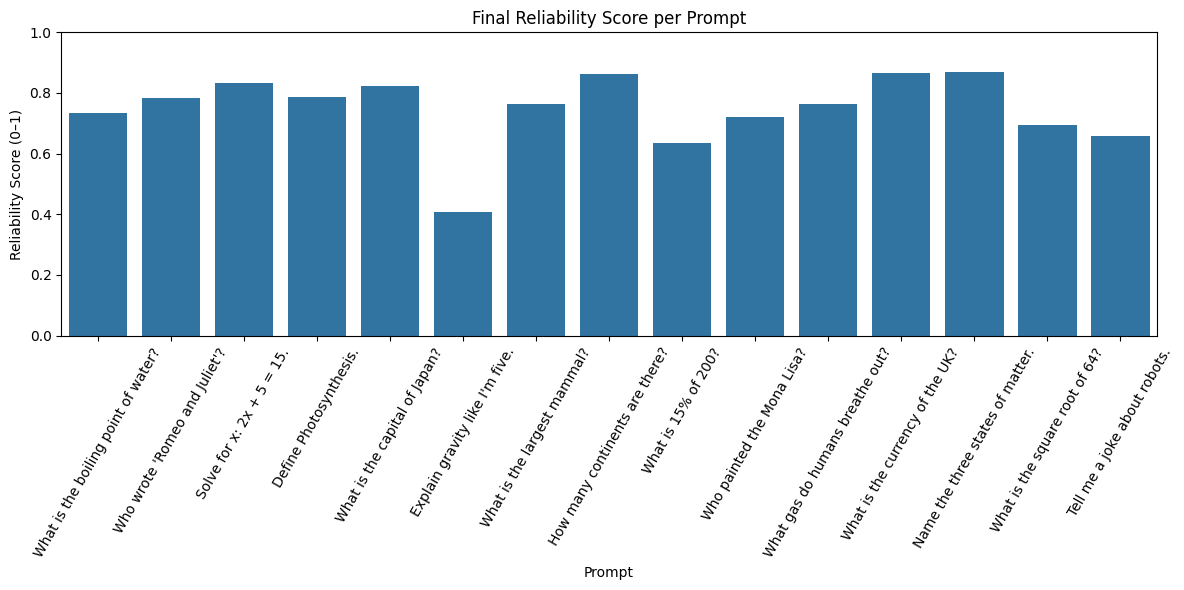

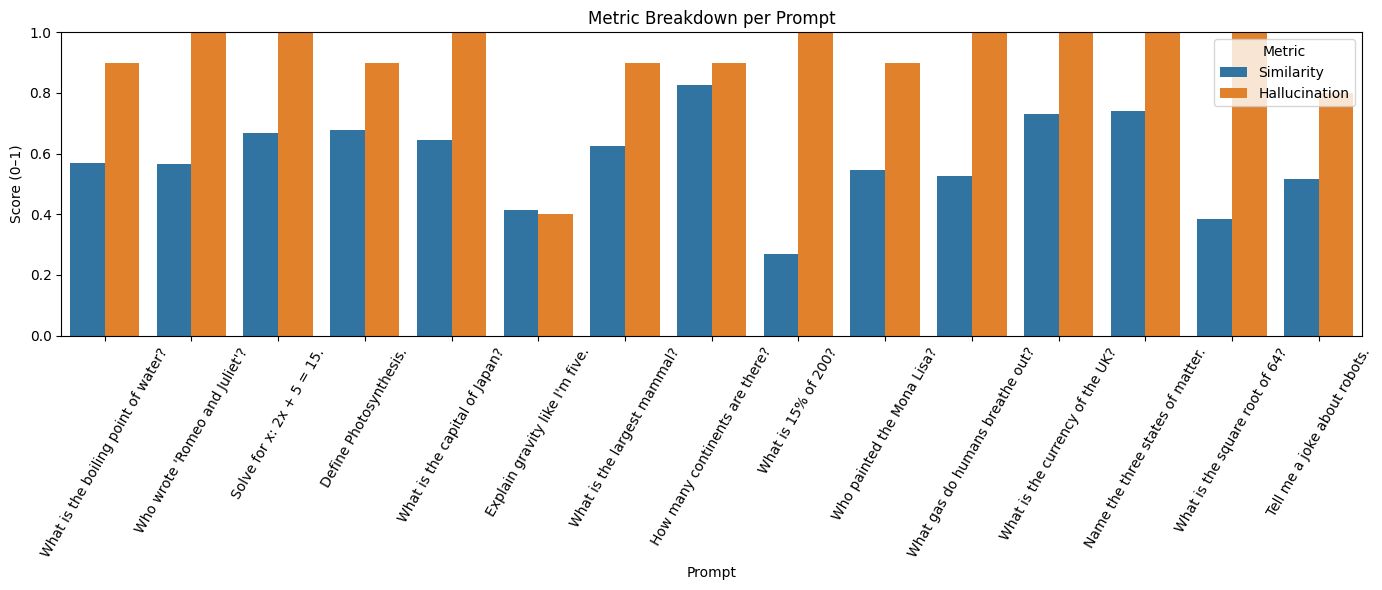

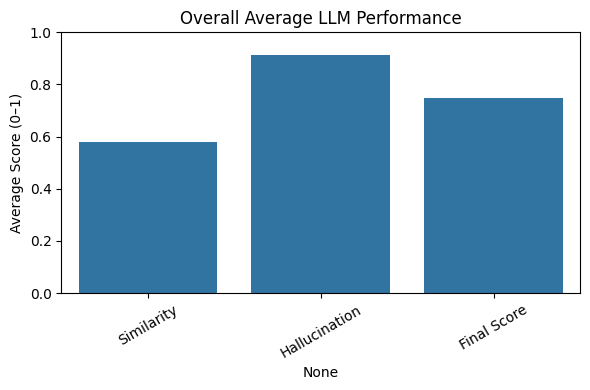

,0
Similarity,0.580713
Hallucination,0.913333
Final Score,0.747023


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

sns.barplot(data=df, x="Prompt", y="Final Score")

plt.xticks(rotation=60)
plt.ylim(0, 1)
plt.title("Final Reliability Score per Prompt")
plt.ylabel("Reliability Score (0–1)")
plt.xlabel("Prompt")
plt.tight_layout()
plt.show()

df_melted = df.melt(
    id_vars="Prompt",
    value_vars=["Similarity", "Hallucination"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(14, 6))

sns.barplot(data=df_melted, x="Prompt", y="Score", hue="Metric")

plt.xticks(rotation=60)
plt.ylim(0, 1)
plt.title("Metric Breakdown per Prompt")
plt.ylabel("Score (0–1)")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()

summary = df[["Similarity", "Hallucination", "Final Score"]].mean()

plt.figure(figsize=(6, 4))

sns.barplot(x=summary.index, y=summary.values)

plt.ylim(0, 1)
plt.title("Overall Average LLM Performance")
plt.ylabel("Average Score (0–1)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

summary
